In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
matplotlib.rcParams['font.family'] = 'STSong'
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts import options as opts
from pyecharts.charts import Geo, Map, Timeline
from pyecharts.globals import ChartType, SymbolType, CurrentConfig, NotebookType, ThemeType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from gensim import corpora
from gensim.corpora import Dictionary
import jieba
import stylecloud
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/rumor_text_data_processed.csv', parse_dates=['date'])
df.head(3)

,date,source,source_num,content,core,province,like,log_like,views,all_topic,all_prob,all_emotion,abs_all_emotion,sub_topic,sub_prob,sub_emotion,abs_sub_emotion
0,2022-02-18,北京日报客户端,1,“有人从香港游泳偷渡到深圳湾被捕？”假的！系轻生被救！,有人从香港游泳偷渡到深圳湾被捕？,广东省,0,0.000000,0,4,0.923976,0.974462,0.474462,6,0.869034,0.891570,0.391570
1,2022-02-18,大河报、羊城晚报,2,近日，社交媒体上一则题为“河南一位老爷爷考上清华大学被顶替”的消息引发网友关注和转发。消息称...,河南一位老爷爷考上清华大学被顶替,河南省,41,3.737670,1,3,0.987694,1.000000,0.500000,11,0.847208,0.812769,0.312769
2,2022-02-17,南方都市报、大众网,2,近日，网传“湖南衡阳南岳衡山寺庙高薪招聘住持，月薪高达5万元，弹性工作制，下班后原则上不干预...,湖南衡阳南岳衡山寺庙高薪招聘住持，月薪高达5万元，弹性工作制，下班后原则上不干预私生活,湖南省,26,3.295837,1,3,0.984797,0.999992,0.499992,11,0.949070,0.992183,0.492183


# 3 地理信息挖掘

## 3.1 谣言数量分布地图

按照省份对所有谣言分组统计条数。

In [3]:
data = pd.DataFrame(df.groupby('province')['content'].count()).reset_index().values
data

array([['上海市', 12],
       ['内蒙古自治区', 1],
       ['北京市', 17],
       ['吉林省', 2],
       ['四川省', 19],
       ['天津市', 11],
       ['宁夏回族自治区', 2],
       ['安徽省', 8],
       ['山东省', 8],
       ['山西省', 2],
       ['广东省', 15],
       ['广西壮族自治区', 19],
       ['新疆维吾尔自治区', 3],
       ['江苏省', 9],
       ['江西省', 3],
       ['沈阳省', 1],
       ['河北省', 17],
       ['河南省', 15],
       ['浙江省', 63],
       ['海南省', 4],
       ['湖北省', 7],
       ['湖南省', 5],
       ['甘肃省', 1],
       ['福建省', 9],
       ['贵州省', 4],
       ['辽宁省', 10],
       ['重庆市', 2],
       ['陕西省', 37],
       ['黑龙江省', 7]], dtype=object)

In [4]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '谣言数量分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 25))
m.render('map/谣言数量分布地图.html')
m.render_notebook()

## 3.2 谣言热度分布地图

按照省份对所有谣言分组统计点赞量总和。

In [5]:
data = pd.DataFrame(df.groupby('province')['like'].sum()).reset_index().values
data

array([['上海市', 924],
       ['内蒙古自治区', 36],
       ['北京市', 1702],
       ['吉林省', 85],
       ['四川省', 598],
       ['天津市', 927],
       ['宁夏回族自治区', 70],
       ['安徽省', 263],
       ['山东省', 421],
       ['山西省', 226],
       ['广东省', 958],
       ['广西壮族自治区', 1342],
       ['新疆维吾尔自治区', 131],
       ['江苏省', 326],
       ['江西省', 184],
       ['沈阳省', 662],
       ['河北省', 1927],
       ['河南省', 1511],
       ['浙江省', 3653],
       ['海南省', 301],
       ['湖北省', 840],
       ['湖南省', 121],
       ['甘肃省', 25],
       ['福建省', 341],
       ['贵州省', 113],
       ['辽宁省', 2819],
       ['重庆市', 19],
       ['陕西省', 2364],
       ['黑龙江省', 338]], dtype=object)

In [6]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '谣言点赞总量分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 1000))
m.render('map/谣言点赞总量分布地图.html')
m.render_notebook()

一般而言，我们可以用谣言的点赞量作为谣言的热度指标。上面统计的点赞量总和包含了谣言数量和热度这两种信息，为了单独查看每个省份的热度，我们应该以点赞量均值作为指标。

In [7]:
data = pd.DataFrame(df.groupby('province')['like'].mean()).reset_index()
data['like'] = round(data['like'], 2)
data = data.values
data

array([['上海市', 77.0],
       ['内蒙古自治区', 36.0],
       ['北京市', 100.12],
       ['吉林省', 42.5],
       ['四川省', 31.47],
       ['天津市', 84.27],
       ['宁夏回族自治区', 35.0],
       ['安徽省', 32.88],
       ['山东省', 52.62],
       ['山西省', 113.0],
       ['广东省', 63.87],
       ['广西壮族自治区', 70.63],
       ['新疆维吾尔自治区', 43.67],
       ['江苏省', 36.22],
       ['江西省', 61.33],
       ['沈阳省', 662.0],
       ['河北省', 113.35],
       ['河南省', 100.73],
       ['浙江省', 57.98],
       ['海南省', 75.25],
       ['湖北省', 120.0],
       ['湖南省', 24.2],
       ['甘肃省', 25.0],
       ['福建省', 37.89],
       ['贵州省', 28.25],
       ['辽宁省', 281.9],
       ['重庆市', 9.5],
       ['陕西省', 63.89],
       ['黑龙江省', 48.29]], dtype=object)

In [8]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '谣言点赞均值分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 20, max_ = 120))
m.render('map/谣言点赞均值分布地图.html')
m.render_notebook()

## 3.3 谣言情感分布地图

### 3.3.1 详细谣言信息的情感倾向分布

In [9]:
data = pd.DataFrame(df.groupby('province')['all_emotion'].mean()).reset_index()
data['all_emotion'] = round(data['all_emotion'] - 0.5, 4)
data = data.values
data

array([['上海市', -0.0047],
       ['内蒙古自治区', -0.5],
       ['北京市', -0.1597],
       ['吉林省', -0.5],
       ['四川省', -0.1975],
       ['天津市', -0.4996],
       ['宁夏回族自治区', -0.5],
       ['安徽省', -0.125],
       ['山东省', -0.2288],
       ['山西省', -0.0005],
       ['广东省', -0.0979],
       ['广西壮族自治区', -0.339],
       ['新疆维吾尔自治区', -0.4938],
       ['江苏省', -0.1746],
       ['江西省', -0.5],
       ['沈阳省', 0.2976],
       ['河北省', -0.3187],
       ['河南省', -0.2221],
       ['浙江省', -0.3388],
       ['海南省', -0.2541],
       ['湖北省', -0.4995],
       ['湖南省', -0.2999],
       ['甘肃省', -0.3344],
       ['福建省', -0.0987],
       ['贵州省', -0.25],
       ['辽宁省', -0.1415],
       ['重庆市', -0.5],
       ['陕西省', -0.3733],
       ['黑龙江省', -0.4805]], dtype=object)

In [10]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '详细谣言情感倾向分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = -0.5, max_ = 0.5))
m.render('map/详细谣言情感倾向分布地图.html')
m.render_notebook()

### 3.3.2 核心谣言信息的情感倾向分布

In [11]:
data = pd.DataFrame(df.groupby('province')['sub_emotion'].mean()).reset_index()
data['sub_emotion'] = round(data['sub_emotion'] - 0.5, 4)
data = data.values
data

array([['上海市', 0.1208],
       ['内蒙古自治区', -0.496],
       ['北京市', -0.1409],
       ['吉林省', -0.5],
       ['四川省', 0.0432],
       ['天津市', -0.1425],
       ['宁夏回族自治区', 0.1216],
       ['安徽省', -0.1609],
       ['山东省', 0.0995],
       ['山西省', 0.0225],
       ['广东省', 0.2155],
       ['广西壮族自治区', -0.0628],
       ['新疆维吾尔自治区', -0.3545],
       ['江苏省', 0.0886],
       ['江西省', -0.2624],
       ['沈阳省', -0.192],
       ['河北省', -0.1953],
       ['河南省', -0.1486],
       ['浙江省', -0.0652],
       ['海南省', -0.0271],
       ['湖北省', -0.0913],
       ['湖南省', -0.2608],
       ['甘肃省', -0.4729],
       ['福建省', 0.0638],
       ['贵州省', 0.1102],
       ['辽宁省', 0.1124],
       ['重庆市', -0.4767],
       ['陕西省', -0.126],
       ['黑龙江省', 0.0541]], dtype=object)

In [12]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '核心谣言情感倾向分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = -0.5, max_ = 0.5))
m.render('map/核心谣言情感倾向分布地图.html')
m.render_notebook()

### 3.3.3 详细谣言信息的情感强烈程度分布

情感强烈程度需要用情感得分减去0.5的绝对值来计算，绝对值越大，情感越强烈。

In [13]:
df['abs_all_emotion'] = np.abs(df['all_emotion'] - 0.5)
df['abs_sub_emotion'] = np.abs(df['sub_emotion'] - 0.5)

In [14]:
data = pd.DataFrame(df.groupby('province')['abs_all_emotion'].mean()).reset_index()
data['abs_all_emotion'] = round(data['abs_all_emotion'], 4)
data = data.values
data

array([['上海市', 0.4461],
       ['内蒙古自治区', 0.5],
       ['北京市', 0.4715],
       ['吉林省', 0.5],
       ['四川省', 0.4554],
       ['天津市', 0.4996],
       ['宁夏回族自治区', 0.5],
       ['安徽省', 0.5],
       ['山东省', 0.4788],
       ['山西省', 0.4995],
       ['广东省', 0.4933],
       ['广西壮族自治区', 0.4817],
       ['新疆维吾尔自治区', 0.4938],
       ['江苏省', 0.4856],
       ['江西省', 0.5],
       ['沈阳省', 0.2976],
       ['河北省', 0.4899],
       ['河南省', 0.4873],
       ['浙江省', 0.4508],
       ['海南省', 0.4959],
       ['湖北省', 0.4995],
       ['湖南省', 0.4999],
       ['甘肃省', 0.3344],
       ['福建省', 0.4568],
       ['贵州省', 0.5],
       ['辽宁省', 0.4585],
       ['重庆市', 0.5],
       ['陕西省', 0.4571],
       ['黑龙江省', 0.4805]], dtype=object)

In [15]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '详细谣言情感强烈程度分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0.45, max_ = 0.5))
m.render('map/详细谣言情感强烈程度分布地图.html')
m.render_notebook()

### 3.3.4 核心谣言信息的情感强烈程度分布

In [16]:
data = pd.DataFrame(df.groupby('province')['abs_sub_emotion'].mean()).reset_index()
data['abs_sub_emotion'] = round(data['abs_sub_emotion'], 4)
data = data.values
data

array([['上海市', 0.3907],
       ['内蒙古自治区', 0.496],
       ['北京市', 0.4029],
       ['吉林省', 0.5],
       ['四川省', 0.3326],
       ['天津市', 0.3213],
       ['宁夏回族自治区', 0.1216],
       ['安徽省', 0.3996],
       ['山东省', 0.3866],
       ['山西省', 0.4679],
       ['广东省', 0.3507],
       ['广西壮族自治区', 0.2859],
       ['新疆维吾尔自治区', 0.3545],
       ['江苏省', 0.3375],
       ['江西省', 0.3714],
       ['沈阳省', 0.192],
       ['河北省', 0.425],
       ['河南省', 0.4176],
       ['浙江省', 0.3774],
       ['海南省', 0.246],
       ['湖北省', 0.2326],
       ['湖南省', 0.4576],
       ['甘肃省', 0.4729],
       ['福建省', 0.3304],
       ['贵州省', 0.3477],
       ['辽宁省', 0.3913],
       ['重庆市', 0.4767],
       ['陕西省', 0.3466],
       ['黑龙江省', 0.4739]], dtype=object)

In [17]:
m = Map()
m.add('', data, 'china', is_map_symbol_show=False)
m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
m.set_global_opts(title_opts = opts.TitleOpts(title = '核心谣言情感强烈程度分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0.25, max_ = 0.5))
m.render('map/核心谣言情感强烈程度分布地图.html')
m.render_notebook()

## 3.4 6个大主题的地理分布信息

### 3.4.1 谣言数量分布

In [18]:
num_topics = 6
topics = range(num_topics)

data = pd.DataFrame(df.groupby(['all_topic', 'province'])['content'].count()).reset_index()

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.all_topic == i].reset_index(drop = True)[['province', 'content']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['content'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '6个大主题的谣言数量分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 8),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/6个大主题的谣言数量分布地图.html')
timeline.render_notebook()

### 3.4.2 谣言热度分布

点赞总量动态分布图。

In [19]:
data = pd.DataFrame(df.groupby(['all_topic', 'province'])['like'].sum()).reset_index()

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.all_topic == i].reset_index(drop = True)[['province', 'like']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['like'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '6个大主题的谣言点赞总量分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 800),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/6个大主题的谣言点赞总量分布地图.html')
timeline.render_notebook()

点赞均值动态分布图。

In [20]:
data = pd.DataFrame(df.groupby(['all_topic', 'province'])['like'].mean()).reset_index()

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.all_topic == i].reset_index(drop = True)[['province', 'like']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['like'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '6个大主题的谣言点赞均值分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 100),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/6个大主题的谣言点赞均值分布地图.html')
timeline.render_notebook()

### 3.4.3 谣言情感倾向分布

6个大主题的情感倾向分布图。

In [21]:
data = pd.DataFrame(df.groupby(['all_topic', 'province'])['all_emotion'].mean()).reset_index()
data['all_emotion'] = round(data['all_emotion'] - 0.5, 4)

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.all_topic == i].reset_index(drop = True)[['province', 'all_emotion']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['all_emotion'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '6个大主题的谣言情感倾向分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = -0.5, max_ = 0.5),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/6个大主题的谣言情感倾向分布地图.html')
timeline.render_notebook()

### 3.4.4 谣言情感强烈程度分布

6个大主题的情感强烈程度分布图。

In [22]:
data = pd.DataFrame(df.groupby(['all_topic', 'province'])['abs_all_emotion'].mean()).reset_index()
data['abs_all_emotion'] = round(data['abs_all_emotion'], 4)

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.all_topic == i].reset_index(drop = True)[['province', 'abs_all_emotion']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['abs_all_emotion'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '6个大主题的谣言情感强烈程度分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0.46, max_ = 0.5),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/6个大主题的谣言情感强烈程度分布地图.html')
timeline.render_notebook()

## 3.5 12个小主题的地理分布信息

### 3.5.1 谣言数量分布

In [23]:
num_topics = 12
topics = range(num_topics)

data = pd.DataFrame(df.groupby(['sub_topic', 'province'])['content'].count()).reset_index()

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.sub_topic == i].reset_index(drop = True)[['province', 'content']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['content'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '12个小主题的谣言数量分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 8),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/12个小主题的谣言数量分布地图.html')
timeline.render_notebook()

### 3.5.2 谣言热度分布

点赞总量动态分布图。

In [24]:
data = pd.DataFrame(df.groupby(['sub_topic', 'province'])['like'].sum()).reset_index()

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.sub_topic == i].reset_index(drop = True)[['province', 'like']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['like'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '12个小主题的谣言点赞总量分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0, max_ = 400),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/12个小主题的谣言点赞总量分布地图.html')
timeline.render_notebook()

### 3.5.3 谣言情感倾向分布

12个主题的情感倾向分布图。

In [25]:
data = pd.DataFrame(df.groupby(['sub_topic', 'province'])['sub_emotion'].mean()).reset_index()
data['sub_emotion'] = round(data['sub_emotion'] - 0.5, 4)

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.sub_topic == i].reset_index(drop = True)[['province', 'sub_emotion']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['sub_emotion'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '12个小主题的谣言情感倾向分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = -0.5, max_ = 0.5),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/12个小主题的谣言情感倾向分布地图.html')
timeline.render_notebook()

### 3.5.4 谣言情感强烈程度分布

12个主题的情感强烈程度分布图。

In [26]:
data = pd.DataFrame(df.groupby(['sub_topic', 'province'])['abs_sub_emotion'].mean()).reset_index()
data['abs_sub_emotion'] = round(data['abs_sub_emotion'], 4)

timeline = Timeline(init_opts = opts.InitOpts(width = '960px', height = '540px', theme = 'light'))

for i in range(len(topics)):
    tmp = data[data.sub_topic == i].reset_index(drop = True)[['province', 'abs_sub_emotion']]
    attr = list(tmp.iloc[:,0])
    value = list(tmp['abs_sub_emotion'])
    data_pair = []
    for idx in range(len(attr)):
        pair = [attr[idx], value[idx]]
        data_pair.append(pair)
    m = Map()
    m.add(f'topic{i}', data_pair, 'china', is_map_symbol_show=False)
    m.set_series_opts(label_opts = opts.LabelOpts(is_show = False))
    m.set_global_opts(title_opts = opts.TitleOpts(title = '12个小主题的谣言情感强烈程度分布地图', pos_left = 'center'),
                     visualmap_opts = opts.VisualMapOpts(min_ = 0.2, max_ = 0.5),
                     legend_opts=opts.LegendOpts(pos_right='right', pos_top='top'))
    timeline.add(chart = m, time_point = str(topics[i]))
timeline.add_schema(is_auto_play = True, play_interval = 600)
timeline.render('map/12个小主题的谣言情感强烈程度分布地图.html')
timeline.render_notebook()

## 3.6 不同省市的词云图

In [27]:
corpus = list(df.core)
with open('LDA/stopwords_sub.txt', 'r') as f:
    stopwords = [line.strip() for line in f]
num_words = [str(i) for i in range(3000)]
stopwords = stopwords + num_words
tokenlist = [jieba.lcut(text, HMM=True) for text in corpus]
tokenlist = [[t for t in tokens if t not in stopwords] for tokens in tokenlist]
dictionary = corpora.Dictionary(tokenlist)

Building prefix dict from the default dictionary ...
Loading model from cache D:\Temp\jieba.cache
Loading model cost 0.336 seconds.
Prefix dict has been built successfully.


定义画词云图的函数。

In [28]:
def draw_wordcloud(prov, color='Blues'):
    words = []
    for i in df[df.province==prov].index:
        words += tokenlist[i]
    stylecloud.gen_stylecloud(
        text=' '.join(words),
        font_path="wordcloud/STSong.ttf",
        size = 1000,
        icon_name='fas fa-leaf',
        palette='colorbrewer.sequential.' + color + '_7',
        background_color='white',
        max_words=200,
        stopwords=True,
        custom_stopwords=['例新冠', '发现', '发生', '包', '有人', '一名'],
        collocations=False,
        # gradient='horizontal',
        output_name=f'wordcloud/wordcloud{prov}.png'
    )
    return Image(filename = f'wordcloud/wordcloud{prov}.png')

分省统计谣言条数，选取谣言条数最多的前8个省进行词云图展示。

In [29]:
tmp = df.groupby('province')['content'].count().sort_values(ascending=False).head(8).reset_index()
tmp

,province,content
0,浙江省,63
1,陕西省,37
2,四川省,19
3,广西壮族自治区,19
4,河北省,17
5,北京市,17
6,广东省,15
7,河南省,15


In [30]:
colorlist = ['Blues', 'BuPu', 'Greens', 'Greys', 'Oranges', 'PuBu', 'PuRd', 
             'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']

# for i, p in enumerate(tmp['province']):
#     draw_wordcloud(p, colorlist[i])

## 3.6 无地理信息的词云图

无地理信息的谣言也有着共同之处，发现词云图基本脱离了疫情，或是适用于整个国家，或是适用于所有人民，或是来自国外的谣言。

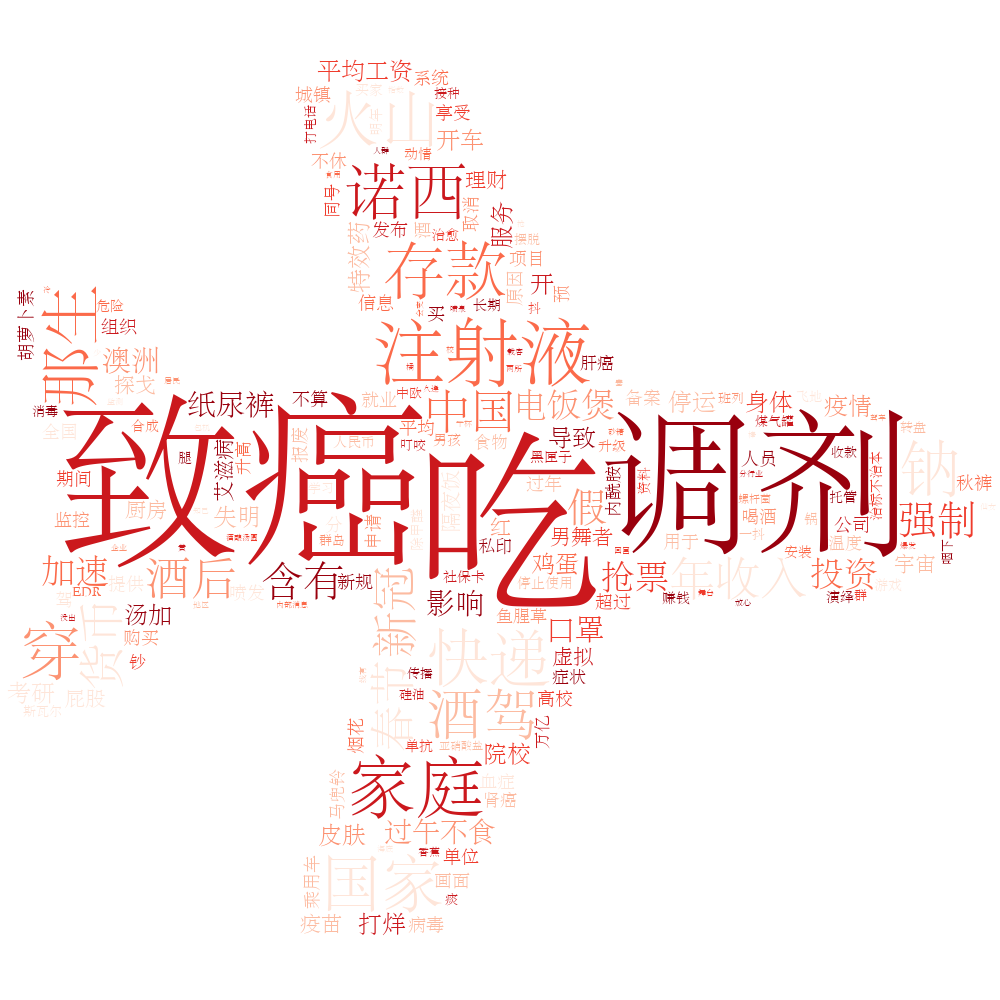

In [31]:
# words = []
# for i in df[df.province.isna()].index:
#     words += tokenlist[i]
# stylecloud.gen_stylecloud(
#     text=' '.join(words),
#     font_path="wordcloud/STSong.ttf",
#     size = 1000,
#     icon_name='fas fa-plane',
#     palette='colorbrewer.sequential.Reds_7',
#     background_color='white',
#     max_words=200,
#     stopwords=True,
#     custom_stopwords=['例新冠', '发现', '发生', '包', '有人', '一名'],
#     collocations=False,
#     # gradient='horizontal',
#     output_name=f'wordcloud/wordcloud无地理信息.png'
# )
Image(filename = f'wordcloud/wordcloud无地理信息.png')